In [8]:
!pip install scikit-image
!pip install tqdm
!pip install opencv-python
!pip install scikit-learn
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tqdm import tqdm

# -----------------------------
# PARAMETERS
# -----------------------------
TRAIN_FOLDER = "C:\\Users\\User\\Downloads\\TRAIN"  # e.g., "train/"
IMAGE_SIZE = (64, 64)
LBP_POINTS = 24
LBP_RADIUS = 3
NUM_HIST_BINS = 32

# -----------------------------
# HELPER FUNCTION
# -----------------------------
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: {image_path} could not be loaded.")
        return None
    
    img = cv2.resize(img, IMAGE_SIZE)
    img_norm = img / 255.0
    
    # Grayscale histogram
    hist = cv2.calcHist([img], [0], None, [NUM_HIST_BINS], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    
    # Edge density
    edges = cv2.Canny((img_norm*255).astype(np.uint8), 100, 200)
    edge_density = np.sum(edges) / (IMAGE_SIZE[0] * IMAGE_SIZE[1])
    
    # LBP texture
    lbp = local_binary_pattern(img, LBP_POINTS, LBP_RADIUS, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=LBP_POINTS + 2, range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    # Combine all features
    features = np.hstack([hist, [edge_density], lbp_hist])
    return features

# -----------------------------
# LOAD DATA
# -----------------------------
X = []
y = []

class_folders = [f for f in os.listdir(TRAIN_FOLDER) if os.path.isdir(os.path.join(TRAIN_FOLDER, f))]
print(f"Found classes: {class_folders}")

for label in class_folders:
    folder_path = os.path.join(TRAIN_FOLDER, label)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in tqdm(image_files, desc=f"Processing {label}"):
        img_path = os.path.join(folder_path, img_file)
        feats = extract_features(img_path)
        if feats is not None:
            X.append(feats)
            y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Optional: save to disk
np.save("X_features.npy", X)
np.save("y_labels.npy", y)

Found classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


Processing NEUTROPHIL: 100%|██████████| 2499/2499 [00:08<00:00, 298.05it/s]

Feature matrix shape: (9957, 59)
Labels shape: (9957,)


In [3]:
print(X)
print(y)

[[0.34978756 0.01013877 0.00217259 ... 0.01782227 0.1418457  0.41040039]
 [0.41212368 0.01463617 0.00077032 ... 0.01586914 0.14501953 0.3918457 ]
 [0.26750165 0.0082655  0.00075141 ... 0.02026367 0.11547852 0.43286133]
 ...
 [0.30804628 0.00714725 0.00071472 ... 0.01513672 0.12329102 0.34594727]
 [0.45626464 0.00489105 0.00209616 ... 0.01831055 0.17358398 0.36450195]
 [0.24443224 0.00396377 0.00066063 ... 0.02514648 0.13305664 0.42407227]]
['EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' ... 'NEUTROPHIL' 'NEUTROPHIL'
 'NEUTROPHIL']


KNN Accuracy: 0.9487951807228916

KNN Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.95      0.94       499
  LYMPHOCYTE       0.96      0.98      0.97       497
    MONOCYTE       0.93      1.00      0.96       496
  NEUTROPHIL       0.98      0.86      0.92       500

    accuracy                           0.95      1992
   macro avg       0.95      0.95      0.95      1992
weighted avg       0.95      0.95      0.95      1992



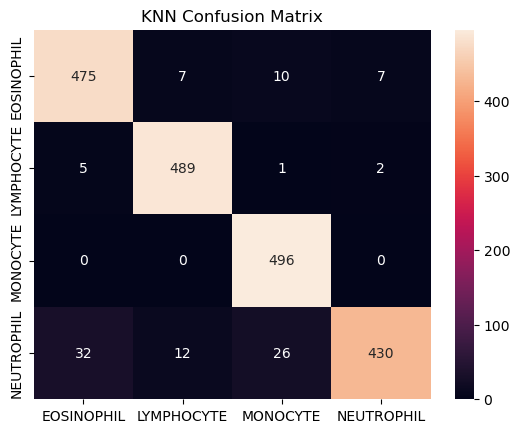

Decision Tree Accuracy: 0.9121485943775101

Decision Tree Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.85      0.86       499
  LYMPHOCYTE       0.97      0.96      0.96       497
    MONOCYTE       0.94      0.96      0.95       496
  NEUTROPHIL       0.87      0.88      0.87       500

    accuracy                           0.91      1992
   macro avg       0.91      0.91      0.91      1992
weighted avg       0.91      0.91      0.91      1992



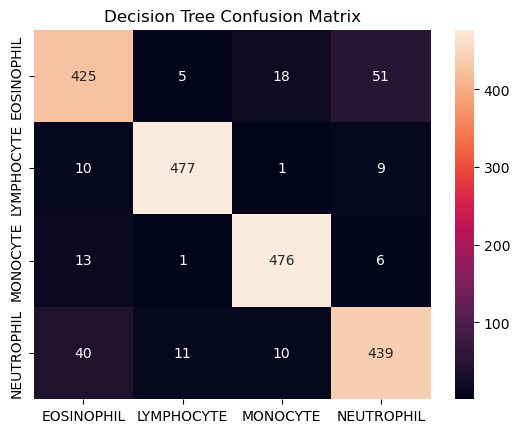

Logistic Regression Accuracy: 0.6285140562248996

Logistic Regression Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.55      0.47      0.51       499
  LYMPHOCYTE       0.69      0.71      0.70       497
    MONOCYTE       0.65      0.74      0.70       496
  NEUTROPHIL       0.61      0.59      0.60       500

    accuracy                           0.63      1992
   macro avg       0.62      0.63      0.62      1992
weighted avg       0.62      0.63      0.62      1992



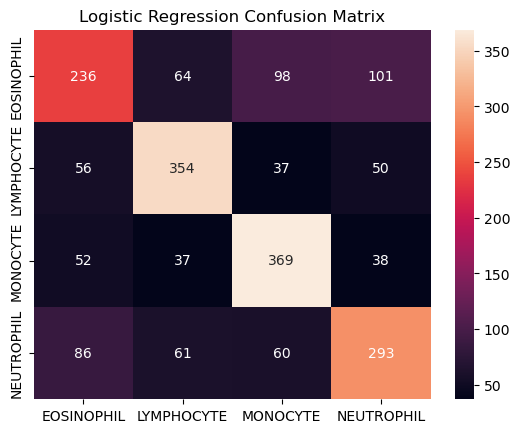

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features (important for KNN / Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ----------------------------
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("KNN Confusion Matrix")
plt.show()

# ----------------------------
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Decision Tree Confusion Matrix")
plt.show()

# ----------------------------
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Logistic Regression Confusion Matrix")
plt.show()
